In [13]:
import numpy as np
import chess
import chess.svg
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
# from torchsummary import summary
from collections import deque
import random
import os
# import datetime
from IPython.display import SVG, display
import ftplib
import hashlib
import json
import math
import multiprocessing as mp
from collections import defaultdict
from stockfish import Stockfish
# from torchview import draw_graph
# import graphviz
# graphviz.set_jupyter_format('png')

In [14]:
pieces_order = 'KQRBNPkqrbnp'  # 12x8x8
castling_order = 'KQkq'
ind = {pieces_order[i]: i for i in range(12)}

def alg_to_coord(alg):
    rank = 8 - int(alg[1])        # 0-7
    file = ord(alg[0]) - ord('a')  # 0-7
    return rank, file


def coord_to_alg(coord):
    letter = chr(ord('a') + coord[1])
    number = str(8 - coord[0])
    return letter + number


def to_planes(fen):
    board_state = replace_tags_board(fen)
    pieces_both = np.zeros(shape=(12, 8, 8), dtype=np.float32)
    for rank in range(8):
        for file in range(8):
            v = board_state[rank * 8 + file]
            if v.isalpha():
                pieces_both[ind[v]][rank][file] = 1
    assert pieces_both.shape == (12, 8, 8)
    return pieces_both


def replace_tags_board(board_san):
    board_san = board_san.split(" ")[0]
    board_san = board_san.replace("2", "11")
    board_san = board_san.replace("3", "111")
    board_san = board_san.replace("4", "1111")
    board_san = board_san.replace("5", "11111")
    board_san = board_san.replace("6", "111111")
    board_san = board_san.replace("7", "1111111")
    board_san = board_san.replace("8", "11111111")
    return board_san.replace("/", "")


def is_black_turn(fen):
    return fen.split(" ")[1] == 'b'

def check_current_planes(realfen, planes):
    cur = planes[0:12]
    assert cur.shape == (12, 8, 8)
    fakefen = ["1"] * 64
    for i in range(12):
        for rank in range(8):
            for file in range(8):
                if cur[i][rank][file] == 1:
                    assert fakefen[rank * 8 + file] == '1'
                    fakefen[rank * 8 + file] = pieces_order[i]

    castling = planes[12:16]
    fiftymove = planes[16][0][0]
    ep = planes[17]

    castlingstring = ""
    for i in range(4):
        if castling[i][0][0] == 1:
            castlingstring += castling_order[i]

    if len(castlingstring) == 0:
        castlingstring = '-'

    epstr = "-"
    for rank in range(8):
        for file in range(8):
            if ep[rank][file] == 1:
                epstr = coord_to_alg((rank, file))

    # realfen = maybe_flip_fen(realfen, flip=is_black_turn(realfen))
    realparts = realfen.split(' ')
    assert realparts[1] == 'w'
    assert realparts[2] == castlingstring
    assert realparts[3] == epstr
    assert int(realparts[4]) == fiftymove
    # realparts[5] is the fifty-move clock, discard that
    return "".join(fakefen) == replace_tags_board(realfen)


def canon_input_planes(fen):
    """
    :param fen:
    :return : (18, 8, 8) representation of the game state
    """
    fen = maybe_flip_fen(fen, is_black_turn(fen))
    return all_input_planes(fen)


def all_input_planes(fen):
    current_aux_planes = aux_planes(fen)

    history_both = to_planes(fen)

    ret = np.vstack((history_both, current_aux_planes))
    assert ret.shape == (18, 8, 8)
    return ret


def maybe_flip_fen(fen, flip=False):
    if not flip:
        return fen
    foo = fen.split(' ')
    rows = foo[0].split('/')

    def swapcase(a):
        if a.isalpha():
            return a.lower() if a.isupper() else a.upper()
        return a

    def swapall(aa):
        return "".join([swapcase(a) for a in aa])
    return "/".join([swapall(row) for row in reversed(rows)]) \
        + " " + ('w' if foo[1] == 'b' else 'b') \
        + " " + "".join(sorted(swapall(foo[2]))) \
        + " " + foo[3] + " " + foo[4] + " " + foo[5]


def aux_planes(fen):
    foo = fen.split(' ')

    en_passant = np.zeros((8, 8), dtype=np.float32)
    if foo[3] != '-':
        eps = alg_to_coord(foo[3])
        en_passant[eps[0]][eps[1]] = 1

    fifty_move_count = int(foo[4])
    fifty_move = np.full((8, 8), fifty_move_count, dtype=np.float32)

    castling = foo[2]
    auxiliary_planes = [np.full((8, 8), int('K' in castling), dtype=np.float32),
                        np.full((8, 8), int('Q' in castling),
                                dtype=np.float32),
                        np.full((8, 8), int('k' in castling),
                                dtype=np.float32),
                        np.full((8, 8), int('q' in castling),
                                dtype=np.float32),
                        fifty_move,
                        en_passant]

    ret = np.asarray(auxiliary_planes, dtype=np.float32)
    assert ret.shape == (6, 8, 8)
    return ret

In [15]:
from glob import glob

model_dir = 'models'
play_data_dir = 'game_data'
play_data_filename_tmpl = "play_%s.json"
# "%s.json"


def collect_all_loaded_data(dataset):
  """
  :return: a tuple containing the data in self.dataset, split into
  (state, policy, and value).
  """
  state_ary, policy_ary, value_ary = dataset

  state_ary1 = np.asarray(state_ary, dtype=np.float32)
  policy_ary1 = np.asarray(policy_ary, dtype=np.float32)
  value_ary1 = np.asarray(value_ary, dtype=np.float32)
  return state_ary1, policy_ary1, value_ary1

def create_uci_labels():
    """
    Creates the labels for the universal chess interface into an array and returns them
    :return:
    """
    labels_array = []
    letters = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
    numbers = ['1', '2', '3', '4', '5', '6', '7', '8']
    promoted_to = ['q', 'r', 'b', 'n']

    for l1 in range(8):
        for n1 in range(8):
            destinations = [(t, n1) for t in range(8)] + \
                           [(l1, t) for t in range(8)] + \
                           [(l1 + t, n1 + t) for t in range(-7, 8)] + \
                           [(l1 + t, n1 - t) for t in range(-7, 8)] + \
                           [(l1 + a, n1 + b) for (a, b) in
                            [(-2, -1), (-1, -2), (-2, 1), (1, -2), (2, -1), (-1, 2), (2, 1), (1, 2)]]
            for (l2, n2) in destinations:
                if (l1, n1) != (l2, n2) and l2 in range(8) and n2 in range(8):
                    move = letters[l1] + numbers[n1] + \
                        letters[l2] + numbers[n2]
                    labels_array.append(move)
    for l1 in range(8):
        l = letters[l1]
        for p in promoted_to:
            labels_array.append(l + '2' + l + '1' + p)
            labels_array.append(l + '7' + l + '8' + p)
            if l1 > 0:
                l_l = letters[l1 - 1]
                labels_array.append(l + '2' + l_l + '1' + p)
                labels_array.append(l + '7' + l_l + '8' + p)
            if l1 < 7:
                l_r = letters[l1 + 1]
                labels_array.append(l + '2' + l_r + '1' + p)
                labels_array.append(l + '7' + l_r + '8' + p)
    return labels_array

def flipped_uci_labels():
    """
    Seems to somehow transform the labels used for describing the universal chess interface format, putting
    them into a returned list.
    :return:
    """
    def repl(x):
        return "".join([(str(9 - int(a)) if a.isdigit() else a) for a in x])

    return [repl(x) for x in create_uci_labels()]


def flip_policy(pol):
    """
    :param pol policy to flip:
    :return: the policy, flipped (for switching between black and white it seems)
    """
    return np.asarray([pol[ind] for ind in unflipped_index])

labels = create_uci_labels()
n_labels = int(len(labels))
flipped_labels = flipped_uci_labels()
unflipped_index = [labels.index(x) for x in flipped_labels]
all_moves2index_dict = {move: i for i, move in enumerate(labels)}
int_to_move = {v: k for k, v in all_moves2index_dict.items()}

In [16]:
class ConvBlock(nn.Module):
    def __init__(self):
        super(ConvBlock, self).__init__()
        self.action_size = 8*8*73
        self.conv1 = nn.Conv2d(18, 256, 5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(256)

    def forward(self, s):
        s = s.view(-1, 18, 8, 8)  # batch_size x channels x board_x x board_y
        s = F.relu(self.bn1(self.conv1(s)))
        return s

class ResBlock(nn.Module):
    def __init__(self, inplanes=256, planes=256, stride=1):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = F.relu(self.bn1(out))
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = F.relu(out)
        return out

class OutBlock(nn.Module):
    def __init__(self):
        super(OutBlock, self).__init__()
        self.conv = nn.Conv2d(256, 4, kernel_size=1) # value head
        self.bn = nn.BatchNorm2d(4)
        self.fc1 = nn.Linear(8*8*4, 256)
        self.fc2 = nn.Linear(256, 1)

        self.conv1 = nn.Conv2d(256, 2, kernel_size=1) # policy head
        self.bn1 = nn.BatchNorm2d(2)
        self.logsoftmax = nn.LogSoftmax(dim=1)
        self.fc = nn.Linear(8*8*2, 1968)

    def forward(self, s):
        v = F.relu(self.bn(self.conv(s))) # value head
        v = v.view(-1, 4*8*8)
        v = F.relu(self.fc1(v))
        v = F.tanh(self.fc2(v))

        p = F.relu(self.bn1(self.conv1(s))) # policy head
        p = p.view(-1, 2*8*8)
        p = self.fc(p)
        p = self.logsoftmax(p).exp()
        return p, v

class ChessNet(nn.Module):
    def __init__(self):
        super(ChessNet, self).__init__()
        self.conv = ConvBlock()
        for block in range(7):
            setattr(self, f"res_{block}", ResBlock())
        self.outblock = OutBlock()

    def forward(self, s):
        s = self.conv(s)
        for block in range(7):
            s = getattr(self, f"res_{block}")(s)
        return self.outblock(s)



In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [18]:

class GameState(chess.Board):
    def __init__(self, fen=None):
        """
        初始化 GameState，默認使用標準起始局面。
        Args:
            fen (str, optional): 用於初始化的 FEN 字符串。
        """
        super().__init__(fen)

    def get_legal_actions(self):
        """
        獲取當前局面下的所有合法動作。
        Returns:
            list[chess.Move]: 一個包含所有合法行棋的列表。
        """
        return list(self.legal_moves)

    def copy_and_apply(self, action):
        """
        創建當前局面的副本，並應用指定的動作。
        Args:
            action (chess.Move): 要執行的動作。
        Returns:
            GameState: 更新後的新局面。
        """
        new_state = GameState(self.fen())
        new_state.push(action)
        return new_state

    def is_game_over(self):
        """
        判斷遊戲是否結束。
        Returns:
            bool: 如果遊戲結束則返回 True，否則 False。
        """
        return super().is_game_over()

    def get_result(self):
        """
        獲取當前局面的結果。
        Returns:
            float: 
                - 1.0: 白方勝利
                - -1.0: 黑方勝利
                - 0.0: 平局
        """
        if self.is_checkmate():
            return 1.0 if self.turn == chess.BLACK else -1.0
        elif self.is_stalemate() or self.is_insufficient_material():
            return 0.0
        return None  # 遊戲尚未結束

    def fen(self):
        """
        返回當前局面的 FEN 表示。
        Returns:
            str: FEN 字符串。
        """
        return super().fen()

In [19]:
class Node:
    def __init__(self, state):
        self.state = GameState(state.fen())           # 棋局狀態 (GameState)
        self.children = {}             # 子節點: {action: Node}
        self.visits = 0                # 節點被訪問次數 N(s)
        self.total_value = 0           # 總回報值 W(s)
        self.policy = None             # 策略分佈 P(s, a)

    def is_leaf(self):
        return len(self.children) == 0

    def expand(self, policy, prune_threshold=0.01,tou = 5):
        """
        擴展節點，基於策略 P(s, a) 和全域 index_to_action 進行剪枝。
        Args:
            policy (list): 動作機率陣列，index 對應到全域變數 index_to_action。
            prune_threshold (float): 剪枝閾值，低於該值的動作將被忽略。
        """
        if tou < 1:
            tou = 1
        global int_to_move  # 使用全域變數
        self.policy = {
            chess.Move.from_uci(int_to_move[i]): p**(1/tou) for i, p in enumerate(policy) if p**(1/tou) >= prune_threshold
        }
        # print(self.policy)
        for action in self.state.get_legal_actions():
            if action in self.policy.keys():
                new_state = self.state.copy_and_apply(action)
                self.children[action] = Node(new_state)

    def select_child(self, c_puct=3.0):
        """
        使用 PUCT 演算法選擇子節點。
        Args:
            c_puct (float): 探索與利用的權衡參數。 越大越喜歡為探索的點
        Returns:
            (action, Node): 最佳動作及其對應子節點。
        """
        total_visits = sum(child.visits for child in self.children.values())
        best_score, best_action, best_node = -float('inf'), None, None

        for action, child in self.children.items():
            q = child.total_value / (child.visits + 1e-6)  # 避免除以 0
            u = c_puct * self.policy[action] * math.sqrt(total_visits) / (1 + child.visits)
            score = q + u
            if score > best_score:
                best_score, best_action, best_node = score, action, child

        return best_action, best_node

    def update(self, value):
        """
        更新節點的訪問次數和回報值。
        Args:
            value (float): 當前模擬的回傳值。
        """
        self.visits += 1
        self.total_value += value


    def best_action(self, temperature=1.0):
        """
        根據訪問次數 N(s, a) 選擇最佳行棋，支持隨機性。
        Args:
            temperature (float): 控制隨機性的參數，越接近 0 越貪婪。
        Returns:
            action: 根據隨機性或最大訪問次數選出的行棋。
        """
        visits = np.array([child.visits for child in self.children.values()])
        actions = list(self.children.keys())
        if actions == []:
            return None
        
        if temperature == 0:  # 純貪婪策略
            return actions[np.argmax(visits)]
        
        # 應用溫度進行概率調整
        probabilities = visits ** (1 / temperature)
        probabilities /= probabilities.sum()
        
        # 隨機抽樣
        # print(probabilities)
        return np.random.choice(actions, p=probabilities)

In [27]:
class MCTS:
    def __init__(self, model, max_depth=15):
        """
        初始化 MCTS。
        Args:
            get_model_p_v (function): 獲取策略 (policy) 和價值 (value) 的神經網路函數。
            max_depth (int): 每次模擬的最大深度。
        """
        self.model = model
        self.max_depth = max_depth

    def search(self, root_state, n_simulations):
        """
        執行 MCTS 搜索。
        Args:
            root_state (GameState): 初始遊戲狀態。
            n_simulations (int): 模擬次數。
        Returns:
            Node: MCTS 搜索後的根節點。
        """
        root = Node(GameState(root_state.fen()) )

        for _ in range(n_simulations):
            node = root
            path = []
            depth = 0

            # Selection
            while not node.is_leaf() and depth < self.max_depth:
                action, node = node.select_child()
                path.append(node)
                depth += 1

            # Expansion
            if not node.state.is_game_over() and depth < self.max_depth:
                policy, value = self.model(torch.FloatTensor(np.array(canon_input_planes(node.state.fen()))).unsqueeze(0).to(device))
                policy = policy.squeeze(0).detach().cpu().numpy()
                value = value.squeeze(0).detach().cpu().numpy()
                if is_black_turn(node.state.fen()):
                    policy = flip_policy(policy)
                node.expand(policy)
            else:
                # 如果遊戲結束或達到模擬深度，直接返回當前值
                if node.state.is_game_over():
                    value = node.state.get_result()
                else:
                    policy, value = self.model(torch.FloatTensor(np.array(canon_input_planes(node.state.fen()))).unsqueeze(0).to(device))
                    # policy = policy.squeeze(0).detach().cpu().numpy()
                    value = value.squeeze(0).detach().cpu().numpy()
                    # if is_black_turn(node.state.fen()):
                    #     policy = flip_policy(policy)

            # Backpropagation
            for ancestor in reversed(path):
                ancestor.update(value)
                value = -value  # 翻轉值，因對手的收益是自己的損失

        return root

In [28]:
class ChessAgent:
    def __init__(self, name, device, path=None):
        self.name = name
        self.device = device
        self.model = ChessNet().to(device)
        self.model.eval()

        if path:
          self.load_model(model_dir,path)
          self.model.to(device)
        else:
          pass

    def load_model(self, dir, filename):
        """Load a model from disk."""
        if os.path.exists(os.path.join(dir,filename)):
            # save_data = torch.load(os.path.join(dir,filename))
            save_data = torch.load(os.path.join(dir,filename),map_location=device)
            self.model.load_state_dict(save_data['model_state'])
            print(f"Model loaded from {filename}")
            return True
        return False

    def save_model(self,dir, filename):
        """Save a model to disk."""
        save_data = {
            'model_state': self.model.state_dict()
        }
        path = os.path.join(dir,filename)
        torch.save(save_data, path)
        print(f"Model saved to {path}")

    def choose_action(self, board,max_depth = 15,n_simulations=1000,mode = 'tree'):
        """Choose action by probability."""
        if mode == 'mcts':
            n_move = int(board.fen().split(' ')[-1])
            # move = mcts(board,self.model,n_simulations=n_simulations,temperature=(1/n_move)*5)
            move = mcts(board,self.model,n_simulations=n_simulations,temperature = 1.0)
            if move is None:
                print('give up')
                move = random.choice(list(board.legal_moves))
            return move.uci()
        elif mode == 'tree':
            tree = MCTS(self.model, max_depth=max_depth)
            root = tree.search(board, n_simulations=n_simulations)
            move = root.best_action(temperature = 1.0)
            if move is None:
                move = random.choice(list(board.legal_moves))
            return move.uci()

    def get_best_move(self, board):
        policy,value = self.model(torch.FloatTensor(np.array(canon_input_planes(board.fen()))).to(device))
        policy = policy.squeeze().cpu().detach().numpy()
        value = value.squeeze().cpu().detach().numpy()
        if is_black_turn(board.fen()):
            policy = flip_policy(policy)
        legal_moves = list(board.legal_moves)
        legal_moves_uci = [move.uci() for move in legal_moves]
        sorted_indices = np.argsort(policy)[::-1]
        for move_index in sorted_indices:
            move = int_to_move[move_index]
            if move in legal_moves_uci:
                return move
        return None
# agent = ChessAgent('test',device,'')

In [34]:
class AIVSstockfish:
    def __init__(self):
        self.board = chess.Board()
        self.stockfish = Stockfish(path="stockfish/stockfish-ubuntu-x86-64-avx2")
        self.stockfish.set_depth(5)
        self.stockfish.set_elo_rating(250)
        self.agent = ChessAgent(None,device,'train_1211_300.pt')
        # stockfish.set_fen_position(board.fen())
        # print(stockfish.get_best_move())

    def display_board(self):
        """Display the current board state."""
        return self.board

    def get_stockfish_move(self):
        """Get a move from the user."""
        self.stockfish.set_fen_position(self.board.fen())
        return chess.Move.from_uci(self.stockfish.get_best_move())

    def get_model_move(self):
        """Get a move from the AI model."""
        return chess.Move.from_uci(self.agent.choose_action(self.board))

    def play_game(self,stockfish_color=chess.WHITE):
        """Play a game between stockfish and AI."""
        import time
        while not self.board.is_game_over():
            display(self.display_board())
            time.sleep(1)
            is_stockfish_turn = (self.board.turn == stockfish_color)

            if is_stockfish_turn:
                move = self.get_stockfish_move()
                if move == 'stop':
                    break
            else:
                print("AI is thinking...")
                move = self.get_model_move()
                print(f"AI plays: {move.uci()}")

            self.board.push(move)

        if move == 'stop':
            print('game stop')
            return 0
        # Game over
        display(self.display_board())
        result = self.board.outcome()
        if result.winner is None:
            print("Game drawn!")
        else:
            winner = "White" if result.winner else "Black"
            print(f"{winner} wins!")

/tmp/ipykernel_3839055/3279505294.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  save_data = torch.load(os.path.join(dir,filename),map_location=device)


Model loaded from train_1211_300.pt


Choose stockfish color (white/black):  white


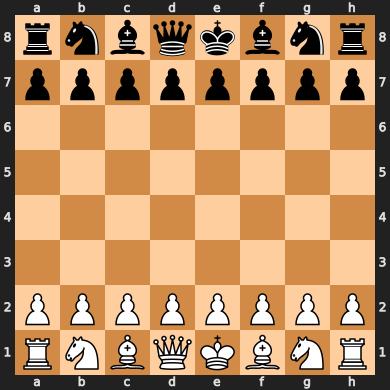

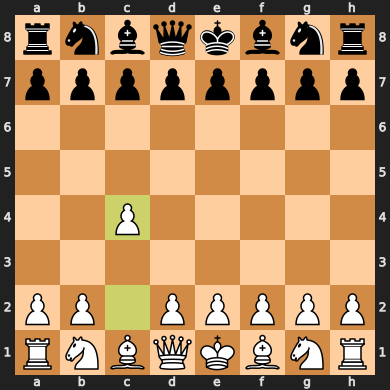

AI is thinking...
AI plays: c7c6


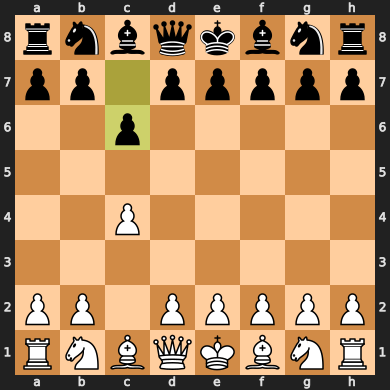

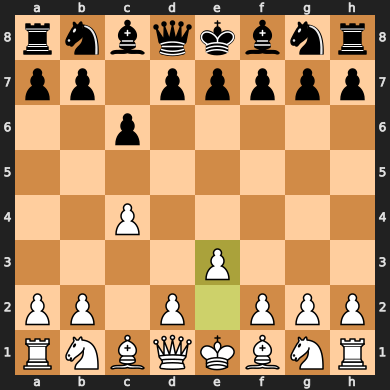

AI is thinking...
AI plays: h7h5


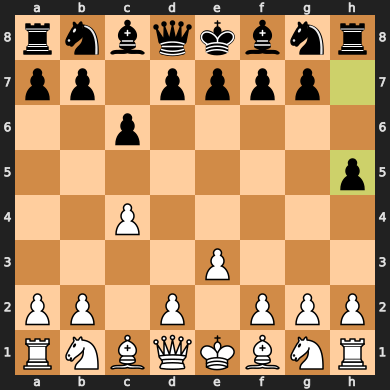

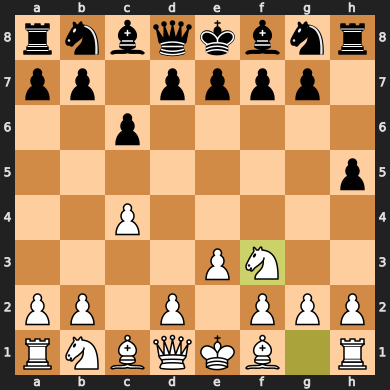

AI is thinking...
AI plays: d7d6


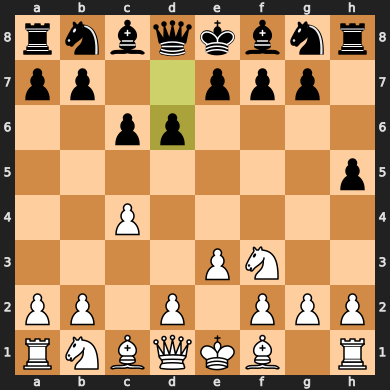

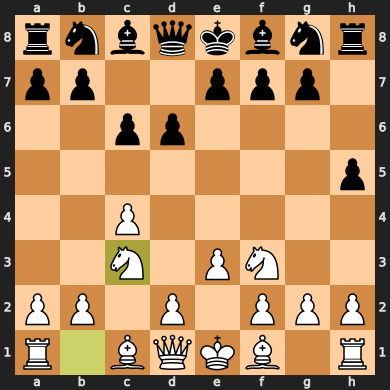

AI is thinking...
AI plays: h5h4


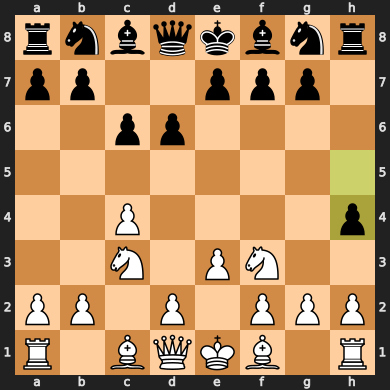

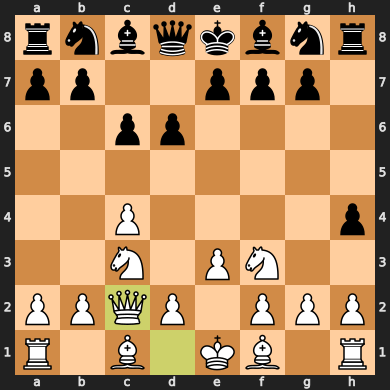

AI is thinking...
AI plays: a7a5


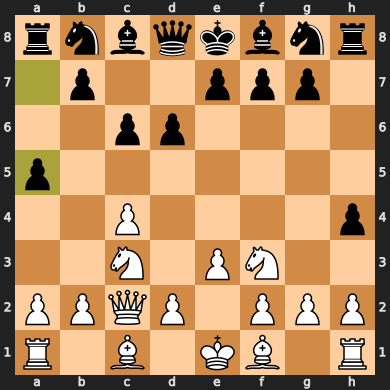

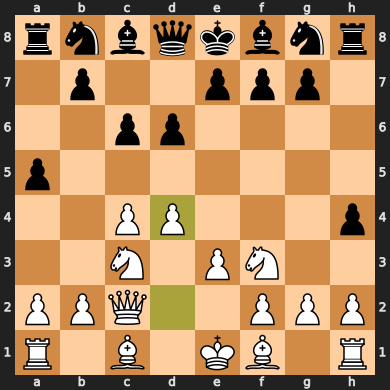

AI is thinking...
AI plays: h8h7


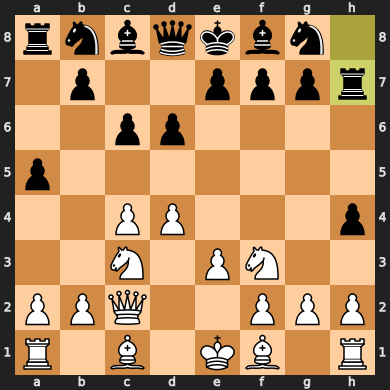

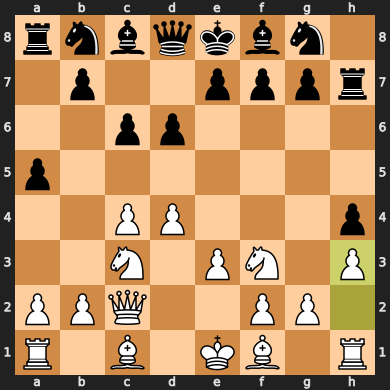

AI is thinking...
AI plays: h7h5


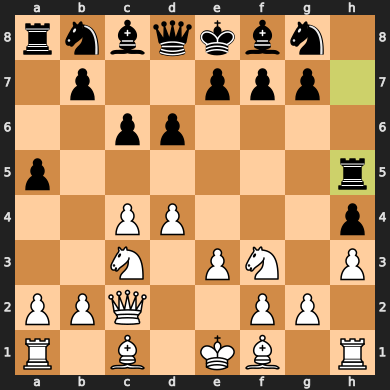

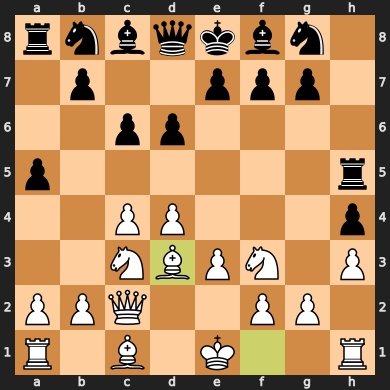

AI is thinking...
AI plays: b7b5


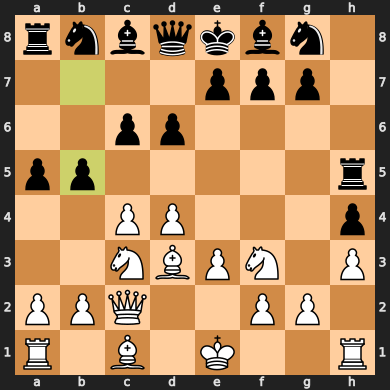

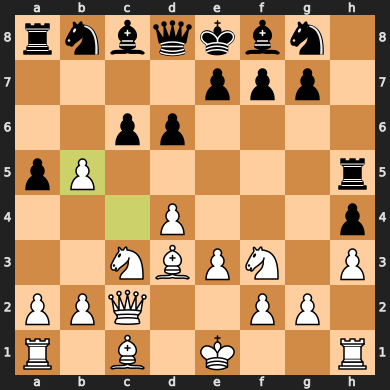

AI is thinking...
AI plays: d8b6


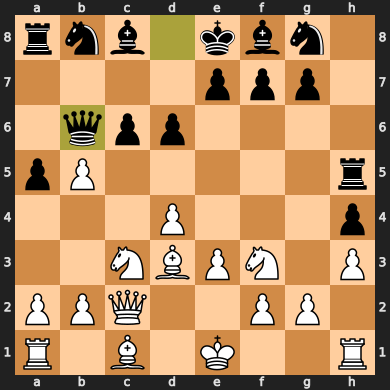

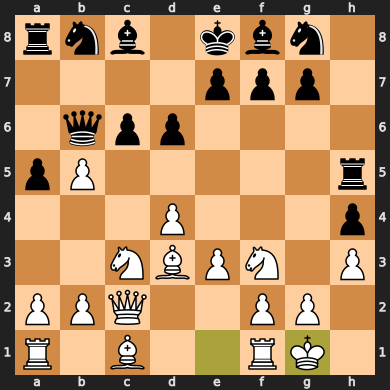

AI is thinking...
AI plays: g8h6


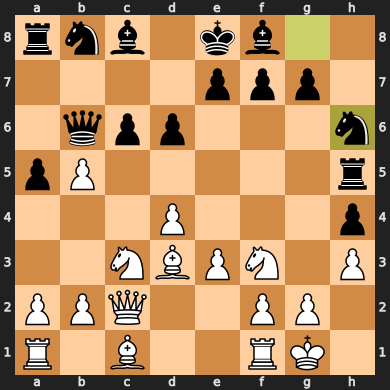

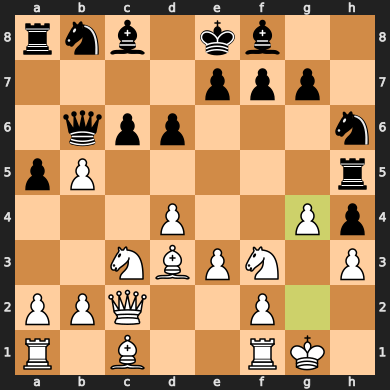

AI is thinking...
AI plays: g7g5


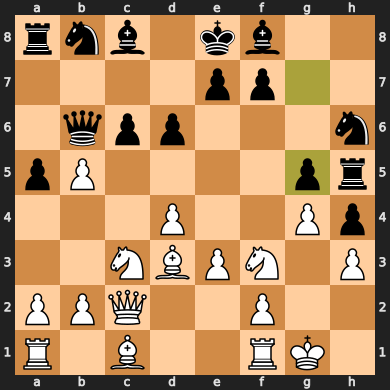

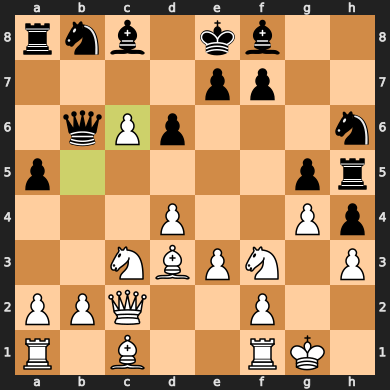

AI is thinking...
AI plays: b6b2


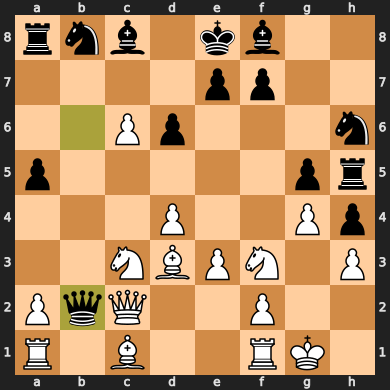

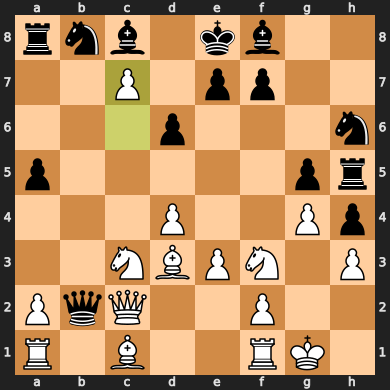

AI is thinking...
AI plays: b2c3


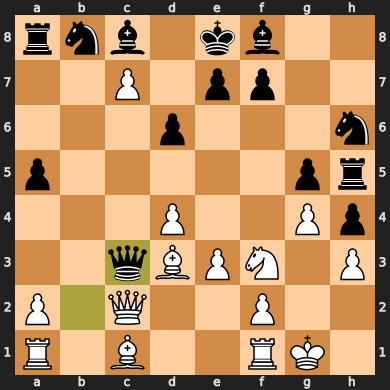

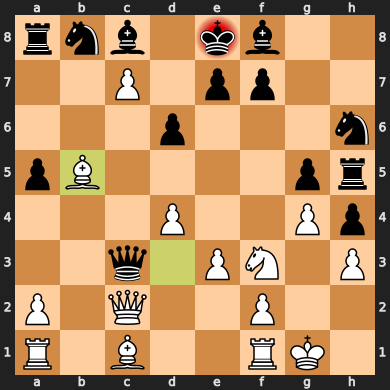

AI is thinking...
AI plays: b8d7


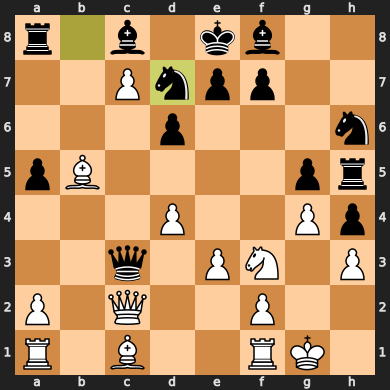

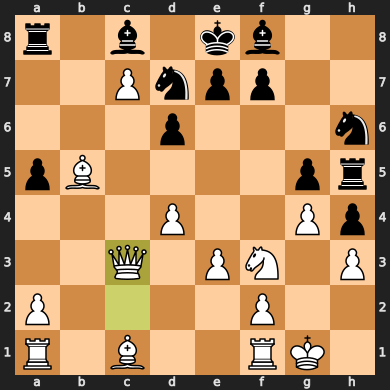

AI is thinking...


KeyboardInterrupt: 

In [35]:
game = AIVSstockfish()

while True:
    color = input("Choose stockfish color (white/black): ").lower()
    if color in ['white', 'black']:
        stockfish_color = chess.WHITE if color == 'white' else chess.BLACK
        game.play_game(stockfish_color=stockfish_color)
    print("Done")
